In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler

# 1. First glimpse at the data

In [3]:
df = pd.read_csv('time_series_temperature.csv')
print(df.head(10))
print(df.tail(10))

   source_id                      datetime        property_name  temperature
0  MICDEV001  2019-04-13T17:51:16.000+0000  heating_temperature         33.3
1  MICDEV001  2019-04-13T17:51:16.000+0000  cooling_temperature         15.0
2  MICDEV001  2019-04-13T18:51:18.000+0000  heating_temperature         34.0
3  MICDEV001  2019-04-13T19:51:20.000+0000  heating_temperature         33.8
4  MICDEV001  2019-04-13T20:51:21.000+0000  heating_temperature         34.2
5  MICDEV001  2019-04-13T21:51:23.000+0000  heating_temperature         34.5
6  MICDEV001  2019-04-13T22:51:25.000+0000  heating_temperature         34.7
7  MICDEV001  2019-04-13T23:51:26.000+0000  heating_temperature         34.8
8  MICDEV001  2019-04-14T00:51:28.000+0000  heating_temperature         34.9
9  MICDEV001  2019-04-14T01:51:30.000+0000  heating_temperature         35.0
     source_id                      datetime        property_name  temperature
990  MICDEV001  2020-01-21T11:28:35.000+0000  cooling_temperature         

In [4]:
print(df.shape)
print(df.dtypes)

(1000, 4)
source_id         object
datetime          object
property_name     object
temperature      float64
dtype: object


### <u>Initial thoughts</u>:
* column "source_id": type string: takes only a single value?
* column "datetime": type string: change type to dates?
* column "property_name": type string: takes only two values?
* column "temperature": type float64: single decimal digit

$\Rightarrow$ 1000 samples of cool/heat temperatures recorded across roughly a year?

# 2. Data Preparation

In [5]:
### are there missing values?
df = df.replace(['NaN', 'None', ''], np.nan)
count_nulls = df.isnull().values.sum()
print(f'Number of missing values: {count_nulls}')

Number of missing values: 0


In [6]:
### are there duplicate rows?
count_dups = df.duplicated().values.sum()
print(f'Number of duplicated rows: {count_dups}')

Number of duplicated rows: 0


## 2.1 source_id

In [7]:
### single source data? typos?
unique_ids = df['source_id'].unique()
print(f'Unique ids: {unique_ids}')

Unique ids: ['MICDEV001']


In [8]:
df = df.drop(columns=['source_id']) # not useful

## 2.2 datetime

In [9]:
### datetime type conversion
dtime = pd.to_datetime(df['datetime'])
df['datetime'] = dtime
df = df.sort_values(by=['datetime']) # chronological sorting just in case

## 2.3 property_name

In [10]:
### unique values? typos?
unique_prop = df['property_name'].unique()
print(f'Unique property names: {unique_prop}')

Unique property names: ['heating_temperature' 'cooling_temperature']


## 2.4  temperature

                    temperature                                               \
                          count       mean       std   min   25%   50%   75%   
property_name                                                                  
cooling_temperature       301.0  21.295681  6.763378  14.9  15.0  20.8  28.5   
heating_temperature       699.0  33.075393  3.363579  21.7  32.5  34.2  34.8   

                           
                      max  
property_name              
cooling_temperature  33.6  
heating_temperature  39.4  


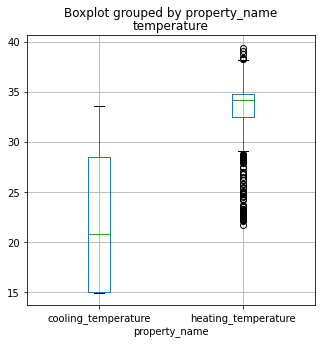

In [11]:
### temperature statistics
df_grouped = df.groupby(by='property_name').describe()
print(df_grouped)
ax = df.boxplot(column=['temperature'], by='property_name', fontsize=10, figsize=(5,5))

### <u>Thoughts</u>:
* this is quiet a weird statistics

cooling:
* left-skewed data because median is closer to first quartile
* the cooling temperature has a high spread and no outliers (as defined by 1.5 interquartile spread around the median)
* around 25% of data is located at around $15^{\circ}$

heating:
* right-skewed because median is closer to third quartile
* the heating temperature has a low spread, but quiet many outliers, especially at lower temperatures
* it is indicative either of anomalous behaviour or mislabeling
* mislabeling might be the reason, because heating is for some reason overrepresented in the data (2x)

$\Rightarrow$ It needs to be discussed on the possible reasons of identified outliers to decide whether or not to remove them from data.

$\Rightarrow$ sampling time intervals for heating and cooling temperatures might indicate labelling errors

# 3. Data analysis

## 3.1 overall sampling rate

independent of whether cooling or heating

In [12]:
min_date = min(dtime)
max_date = max(dtime)
print(f'sampling span: {max_date-min_date}')

sampling span: 285 days 15:05:20


In [13]:
dtime_shift = dtime.shift(1, fill_value=dtime.iloc[-1])
dtime_dt = dtime-dtime_shift # differences between subsequent days
dtime_dt = dtime_dt.iloc[1:] # first row is the total time of sampling => remove
dtime_dt = dtime_dt.sort_values(ascending=False)
dtime_dt = dtime_dt.dt.total_seconds() / 3600  # type conversion: in hours

print(dtime_dt.head(5))
print(dtime_dt.describe())

726    1702.840833
981     965.461667
886     342.283889
636     261.613333
455     211.164722
Name: datetime, dtype: float64
count     999.000000
mean        6.861951
std        65.225502
min         0.000000
25%         0.000000
50%         1.000278
75%         1.000556
max      1702.840833
Name: datetime, dtype: float64


number of simultaneous samplings: 284
longest sampling periods: [70.95170139 40.22756944 14.2618287  10.90055556  8.79853009] days


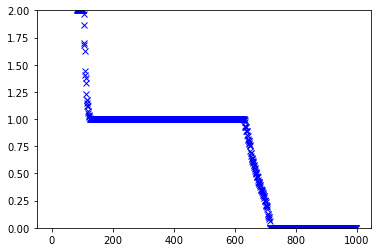

In [14]:
y = dtime_dt.values
print(f'number of simultaneous samplings: {np.sum(y == 0)}') 
print(f'longest sampling periods: {y[:5]/24} days') 

plt.ylim([0, 2])
plt.plot(y, 'bx')

### Thoughts:

* there seem to exist huge time gaps in the overall sampling period, the most extreme ones are 70 and 40 days
* the majority of gaps are below 2 hours
* there are almost 284 simultaneous data points, which account for 57% of our overall data.
* given that around 300 data point are cooling temperaturess, it means that almost every cooling temp is accompanied by a corresponding heating temp, both recorded at the same time
* and that roughly every second heating temperature has been recorded without corresponding cooling temperature

## 3.2 Creating a table where cooling and heating have been recorded at the same time

might help to spot some inconsistencies in the data if present

In [15]:
mask = df['datetime'].duplicated()
mask_twin = mask.shift(-1, fill_value=False)
df_cut = df[np.logical_or(mask, mask_twin)]

print(df_cut.head(10))

                    datetime        property_name  temperature
0  2019-04-13 17:51:16+00:00  heating_temperature         33.3
1  2019-04-13 17:51:16+00:00  cooling_temperature         15.0
14 2019-04-14 10:25:16+00:00  cooling_temperature         20.9
13 2019-04-14 10:25:16+00:00  heating_temperature         34.2
15 2019-04-14 10:43:38+00:00  heating_temperature         34.5
16 2019-04-14 10:43:38+00:00  cooling_temperature         20.4
17 2019-04-14 11:39:32+00:00  heating_temperature         33.9
18 2019-04-14 11:39:32+00:00  cooling_temperature         32.3
21 2019-04-14 13:24:43+00:00  heating_temperature         34.8
22 2019-04-14 13:24:43+00:00  cooling_temperature         15.0


In [16]:
df_cut_c = df_cut[ df_cut['property_name'] == 'cooling_temperature']
df_cut_h = df_cut[ df_cut['property_name'] == 'heating_temperature']
df_sim = df_cut_c.merge(df_cut_h, on='datetime')

                    temperature                                           \
                          count       mean       std   min     25%   50%   
property_name                                                              
cooling_temperature       284.0  21.197887  6.709562  14.9  15.000  20.7   
heating_temperature       284.0  30.758099  4.003855  21.7  28.575  32.4   

                                   
                        75%   max  
property_name                      
cooling_temperature  26.975  33.6  
heating_temperature  33.900  36.4  


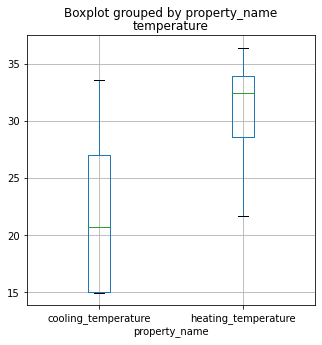

In [17]:
### temperature statistics
df_sim_grouped = df_cut.groupby(by='property_name').describe()
print(df_sim_grouped)
ax = df_cut.boxplot(column=['temperature'], by='property_name', fontsize=10, figsize=(5,5))

### Thoughts:

* in the sub-sampled data looks there are no outliers
* the spread of heating has increased

## 3.3 cooling and heating separately

<AxesSubplot:title={'center':'cooling temperature'}, xlabel='datetime'>

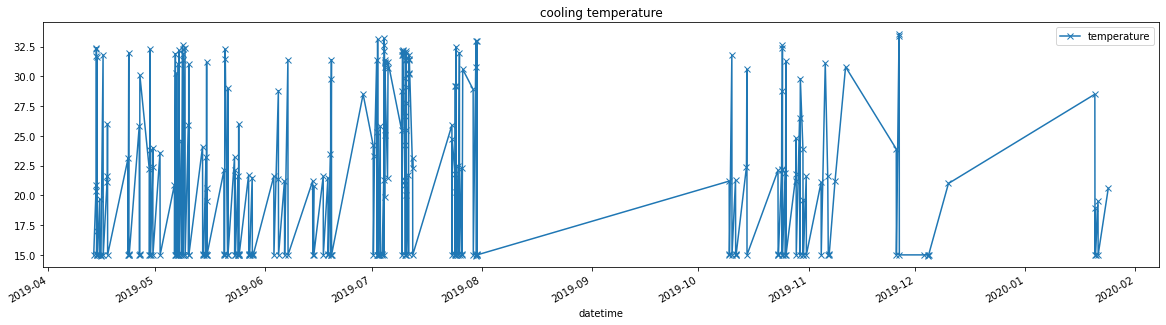

In [18]:
df_cool = df[ df['property_name'] == 'cooling_temperature'].copy()
df_cool.plot(x='datetime', y='temperature', marker='x', figsize=(20,5), title='cooling temperature')

<AxesSubplot:title={'center':'heating temperature'}, xlabel='datetime'>

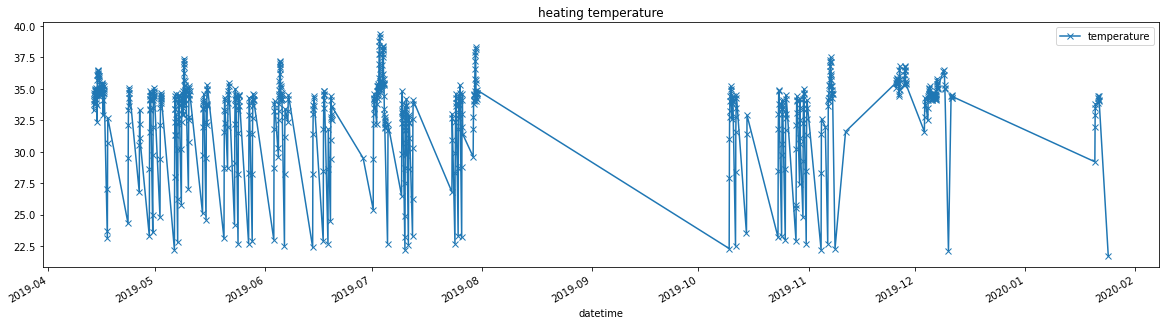

In [19]:
df_heat = df[ df['property_name'] == 'heating_temperature'].copy()
df_heat.plot(x='datetime', y='temperature', marker='x', figsize=(20,5), title='heating temperature')

### Thoughts:
* we see two large gaps in the time series

# 4. Forecasting Future Values

## 4.1 Train and Test sets

In [20]:
### elapsed time
df_heat['elapsed_time'] = (df_heat['datetime'] - df_heat['datetime'].min()).dt.total_seconds()
m = df_heat.shape[0]

### where to split the data? at the largest time gap (see before)
thres = df_heat[ df_heat['datetime'] <= df['datetime'].iloc[725] ].shape[0]/m
print(f'split percentage: {thres: .3f}')

### normalization of data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df_heat[['temperature', 'elapsed_time']])

### training and test sets
data_train = data[:int(len(data)*thres)]
data_test = data[int(len(data)*thres):]

print(data_train.shape)
print(data_test.shape)

split percentage:  0.702
(490, 2)
(209, 2)


## 4.2 LSTM model

In [21]:
### Convert the data into an appropriate input
look_back = 10 # how many recent observations serve to guess the next value
train_x = [] # container for features
train_y = [] # container for labels
for i in range(len(data_train) - look_back - 1):
    train_x.append(data_train[i:(i+look_back), :]) # 10x2 blocks
    train_y.append(data_train[i+look_back, 0]) # corresponding next value
train_x = np.array(train_x)
train_y = np.array(train_y)

print(train_x[0])
print(train_y[0])

[[6.55367232e-01 0.00000000e+00]
 [6.94915254e-01 1.45958072e-04]
 [6.83615819e-01 2.91916143e-04]
 [7.06214689e-01 4.37833694e-04]
 [7.23163842e-01 5.83791765e-04]
 [7.34463277e-01 7.29749837e-04]
 [7.40112994e-01 8.75667387e-04]
 [7.45762712e-01 1.02162546e-03]
 [7.51412429e-01 1.16758353e-03]
 [7.57062147e-01 1.89729285e-03]]
0.7175141242937852


In [50]:
### The LSTM + Dense
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [62]:
### Train the model
model.fit(train_x, train_y, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
479/479 - 2s - loss: 0.0083 - 2s/epoch - 3ms/step
Epoch 2/50
479/479 - 2s - loss: 0.0092 - 2s/epoch - 3ms/step
Epoch 3/50
479/479 - 2s - loss: 0.0093 - 2s/epoch - 3ms/step
Epoch 4/50
479/479 - 2s - loss: 0.0091 - 2s/epoch - 3ms/step
Epoch 5/50
479/479 - 2s - loss: 0.0102 - 2s/epoch - 3ms/step
Epoch 6/50
479/479 - 2s - loss: 0.0089 - 2s/epoch - 3ms/step
Epoch 7/50
479/479 - 2s - loss: 0.0104 - 2s/epoch - 4ms/step
Epoch 8/50
479/479 - 2s - loss: 0.0084 - 2s/epoch - 4ms/step
Epoch 9/50
479/479 - 2s - loss: 0.0085 - 2s/epoch - 4ms/step
Epoch 10/50
479/479 - 2s - loss: 0.0099 - 2s/epoch - 4ms/step
Epoch 11/50
479/479 - 2s - loss: 0.0091 - 2s/epoch - 4ms/step
Epoch 12/50
479/479 - 2s - loss: 0.0084 - 2s/epoch - 3ms/step
Epoch 13/50
479/479 - 2s - loss: 0.0096 - 2s/epoch - 4ms/step
Epoch 14/50
479/479 - 2s - loss: 0.0079 - 2s/epoch - 4ms/step
Epoch 15/50
479/479 - 2s - loss: 0.0092 - 2s/epoch - 4ms/step
Epoch 16/50
479/479 - 2s - loss: 0.0084 - 2s/epoch - 4ms/step
Epoch 17/50
479/4

In [59]:
### Predict and Evaluate
test_x = []
test_y = []
for i in range(len(data_test) - look_back - 1):
    test_x.append(data_test[i:(i+look_back), :])
    test_y.append(data_test[(i+look_back), 0])
test_x = np.array(test_x)
test_y = np.array(test_y).reshape(-1,1)
yhat = model.predict(test_x)

model.evaluate(test_x,test_y)

7/7 [==============================] - 0s 2ms/step - loss: 0.0580


0.05802365392446518

## 4.3 Plot Real vs Predicted

In [60]:
### transform predictions back into a usable format
data_back = np.vstack((yhat.reshape(-1), data_test[look_back+1:,1])).T
data_back = scaler.inverse_transform(data_back)
df_hat = pd.DataFrame(data_back, columns=['temperature_hat','elapsed_time'])

df_heat_new = df_heat.merge(df_hat, on='elapsed_time')

<AxesSubplot:title={'center':'heating temperature'}, xlabel='datetime'>

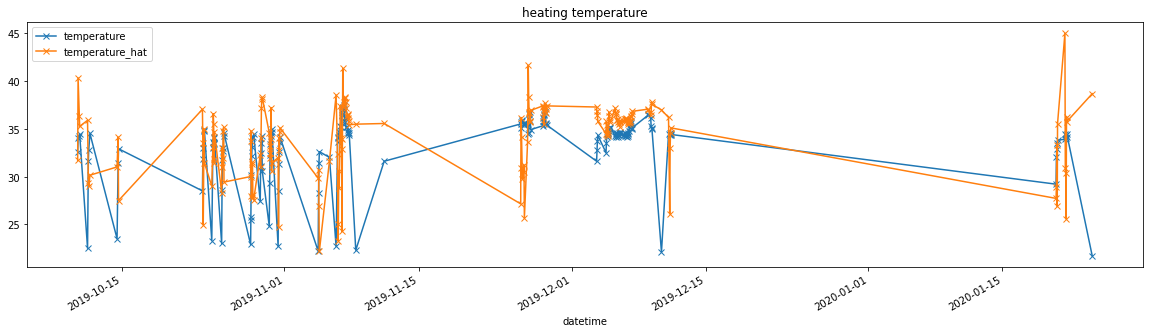

In [61]:
df_heat_new.plot(x='datetime', y=['temperature','temperature_hat'], marker='x', figsize=(20,5), title='heating temperature')

# 5. Anomaly Detection

One can now define a threshold value to alert us whenever our prediction devaites strongly from observation

# 6 Outlook
* model improvements based on different hyperparameters, e.g. number units and/or number/type of layers
* obtain more data to improve predictions
* try alternative models: ARIMA, SARIMA, RNNs